<a href="https://colab.research.google.com/github/godblessourdeadkotatsu/lecture-notes-2024-25/blob/main/IDM/Lab_3_Anomaly_Detection_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection Part 2 (Real-world Use Case)

This exercise detects anomalies in the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) using different ML tecqniques. This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. We simplify the dataset splitting the data in samples with normal rhythm and samples with anormal rhythm. We are interested in identifying the abnormal rhythms. Inspired from [exercise](https://ml-lectures.org/docs/unsupervised_learning/Anomaly_Detection_RNN_AE_VAE.html).

## 0. Requirements

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## 0.5 Accessing google drive (only if using colab)

_Only if using colab_

Upload `housing.csv` to the root of your google drive.
Uncomment and run the next two code **cells** to mount your google drive and load the `housing.csv` data. If not using google drive only run the second one using the correct path to the csv file.

In [ ]:
# Mount google drive

from google.colab import drive
#drive.mount('/content/gdrive')

## 1.0 Data Preprocessing

### 1.1 Loading

We start loading the dataset. First column contains the label, the remaining columns are the features.

In [2]:
# Load the dataset
raw_data = np.genfromtxt('/content/ECG5000.txt').astype("float32")

# Extract labels (first column) ...
labels = raw_data[:, 0] - 1 # We shift normal data `1` to `0`
# ... and features (all remaining 140 columns)
data = raw_data[:, 1:]

### 1.2 Split into train and test data
We use `train_test_split()` to split the data in a train and test data.

In [3]:
# Train-test split
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=42)

### 1.3 Normalize

We use the train split to normalize the data.

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Train transformer on train data, and transform them
train_data = scaler.fit_transform(train_data)

# Apply fitted transformation on test data
test_data = scaler.transform(test_data)

Using the labels we divide the data into normal and anomalous data.
\begin{equation}
\text{basing on}\, on\qquad the\; \text{labels}
\end{equation}

In [5]:
# Convert labels into False (normal) and True (anormal)
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# Select all samples with labels: False -> normal
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

# ... True -> anomaly
anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

What is the split between normal and anomalous data?

In [6]:
ratio = (train_labels == False).astype(int).sum().item() / train_labels.size
print(f"Normal data is {ratio * 100:.2f}%")

Normal data is 58.09%


### 1.4 Plot ECG

Plot a normal ECG.

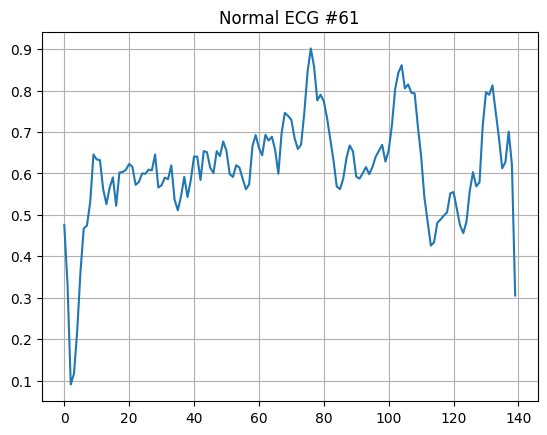

In [7]:
from random import randint

plt.grid()
idx = randint(0, normal_train_data.shape[0])
plt.plot(np.arange(140), normal_train_data[idx])
plt.title(f"Normal ECG #{idx}")
plt.show()

Plot an anomalous ECG.

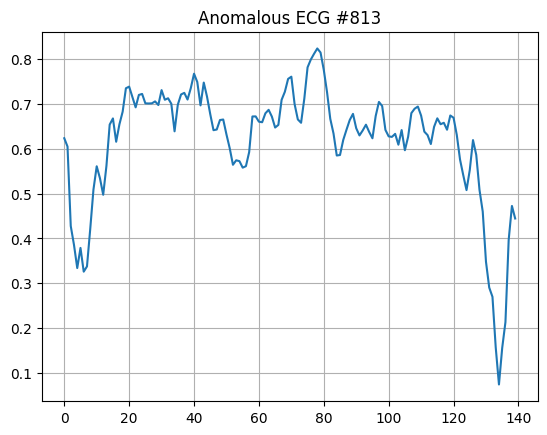

In [8]:
from random import randint
plt.grid()
idx = randint(0, anomalous_train_data.shape[0])
plt.plot(np.arange(140), anomalous_train_data[idx])
plt.title(f"Anomalous ECG #{idx}")
plt.show()

## 2.0 Autoencoder

We start defining the model. We use three layers for both the encoder and the decoder. encoder maps the input to a smaller latent space (with less dimensions). original data is 140 points/features and we map it to a space with 8 dimensions... decoder does the opposite.

In [10]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()

    # Define the encoder network: from 140 features to 8 in three layers
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    # Define the decoder network: from 8 to 140 in three layers
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    # Define how an evaluation of the network is performed
    # We connect the encoder to decoder
    z = self.encoder(x)
    decoded = self.decoder(z)
    return decoded

autoencoder = AnomalyDetector()

### 2.1 Exercise

Look at the code. What is the size of the latent variable `z`?

### 3.0 Training

We train the encoder using the mean absolute error between the original and reconstructed samples. __Notice__: that we use only the normal data to train the model.

In [11]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mae')

In [30]:
# Train the model
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=500,
          batch_size=256,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0149 - val_loss: 0.0146
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0148 - val_loss: 0.0146
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 0.0146
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149 - val_loss: 0.0146
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 0.0146
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0150 - val_loss: 0.0146
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0148 - val_loss: 0.0146
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

Let's look at the convergence of the loss (both train and test data) over the training epochs.

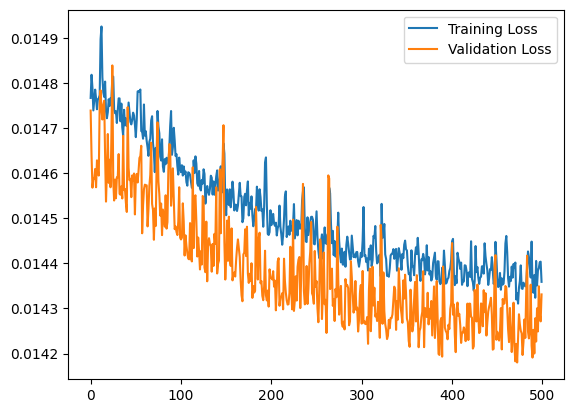

In [31]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

after a while we can trail all we want but we don't get much better ykno.

### 3.1 Examples

Let's also look at normal and anomalous samples while highlighting visually the reconstruction error.

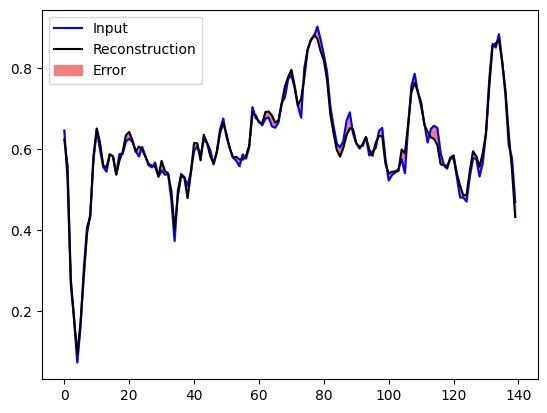

In [32]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'k')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

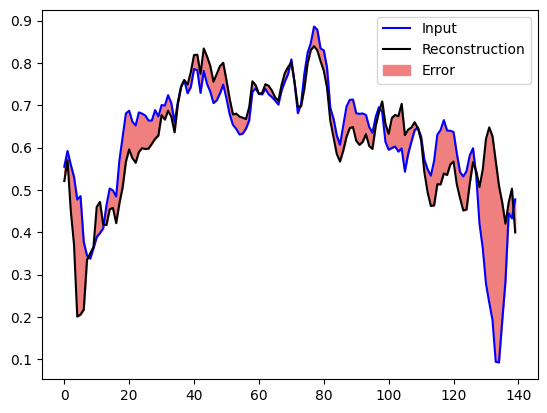

In [24]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'k')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

s

on a anomalous sample there is a bigger error, which is what we EXPECT! we just need **a  threshold** to determine what is an error and what not.

### 3.2 Setting the threshold

To discern normal and anomalous samples we need to set a threshold for the resconstruction error.

We start looking at the distribution of the error over all training samples.

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


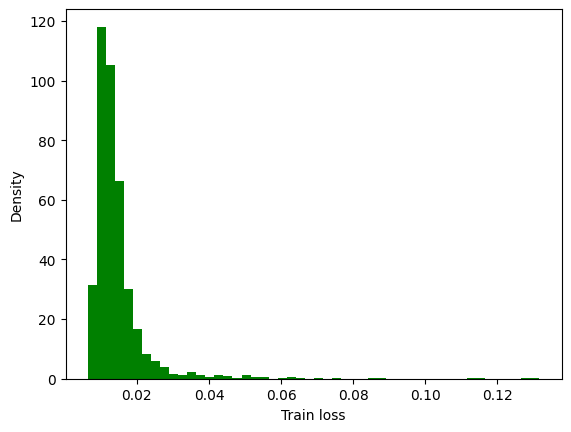

In [33]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss_normal = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss_normal, bins=50, color='g', density=True)
plt.xlabel("Train loss")
plt.ylabel("Density")
plt.show()

this is the empirical distribution of the errors. is it good or nah? it is because we want the distribution to have a center mass and a tail... das sexy

We can set the treshold in many ways. A simple way is to assume that the error is Gaussian distributed and use the sigma rule of thumb: within $1\times\sigma$ lays 68% of the data, within $2\times\sigma$ lays 95% of the data, $3\times\sigma$ lays 99.7% of the data.


---

+++

---



---



---
$\mathfrak{V}\mathfrak{a}\mathfrak{n}\mathfrak{d}\mathfrak{a}\mathfrak{l}\mathfrak{i}\mathfrak{z}\mathfrak{e}\mathsf{this notebook}$

![alt text](https://www.leansixsigmadefinition.com/wp-content/uploads/2019/04/gaussian_distribution.png "")

In [34]:
threshold_ae = np.mean(train_loss_normal) + 1 * np.std(train_loss_normal)
print("Threshold: ", threshold_ae)

Threshold:  0.022643414326012135


Let's check how this threshold compares against the error on the anomalous samples in the train set.

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


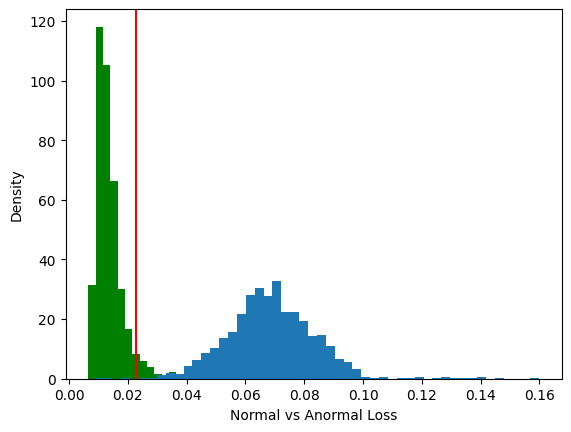

In [35]:
reconstructions = autoencoder.predict(anomalous_train_data)
train_loss_anomalous = tf.keras.losses.mae(reconstructions, anomalous_train_data)

plt.hist(train_loss_normal, bins=50, color='g', density=True)
plt.hist(train_loss_anomalous, bins=50, density=True)

plt.axvline(threshold_ae, c='r')
plt.xlabel("Normal vs Anormal Loss")
plt.ylabel("Density")
plt.show()


### 3.3 Exercise

Try different thresholds.

## 4.0 Detection

We start defining two helper functions. One to predict if a sample is normal or anomalous based on the chosen threshold and one to print the detection stats.

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(threshold, loss)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

Finally, we try the trained model on the test data evaluating: accuracy ($\frac{TP+TN}{TP+FP+TN+FN}$), precision ($\frac{TP}{TP+FP}$), and recall ($\frac{TP}{TP+FN}$).

![Recall](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

In [37]:
preds = predict(autoencoder, test_data, threshold_ae)
print_stats(preds, test_labels)

Accuracy = 0.95
Precision = 0.8863636363636364
Recall = 1.0


### 4.1 Exercise

Which metric it the most important one in the conetxt of anomaly detection? Motivate your choice.